In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

sns.set(style='whitegrid')

# Load data
df = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt', sep=' ', header=None)
df.dropna(axis=1, how='all', inplace=True)

In [3]:
df.columns = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7',
    'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
    'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'
]


In [4]:

print(df.shape)

(20631, 26)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   unit_number     20631 non-null  int64  
 1   time_in_cycles  20631 non-null  int64  
 2   op_setting_1    20631 non-null  float64
 3   op_setting_2    20631 non-null  float64
 4   op_setting_3    20631 non-null  float64
 5   sensor_1        20631 non-null  float64
 6   sensor_2        20631 non-null  float64
 7   sensor_3        20631 non-null  float64
 8   sensor_4        20631 non-null  float64
 9   sensor_5        20631 non-null  float64
 10  sensor_6        20631 non-null  float64
 11  sensor_7        20631 non-null  float64
 12  sensor_8        20631 non-null  float64
 13  sensor_9        20631 non-null  float64
 14  sensor_10       20631 non-null  float64
 15  sensor_11       20631 non-null  float64
 16  sensor_12       20631 non-null  float64
 17  sensor_13       20631 non-null 

In [6]:
print(df.describe())

        unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
count  20631.000000    20631.000000  20631.000000  20631.000000       20631.0   
mean      51.506568      108.807862     -0.000009      0.000002         100.0   
std       29.227633       68.880990      0.002187      0.000293           0.0   
min        1.000000        1.000000     -0.008700     -0.000600         100.0   
25%       26.000000       52.000000     -0.001500     -0.000200         100.0   
50%       52.000000      104.000000      0.000000      0.000000         100.0   
75%       77.000000      156.000000      0.001500      0.000300         100.0   
max      100.000000      362.000000      0.008700      0.000600         100.0   

           sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053

## Dataset Overview

### Structure

* **Rows:** 20,631
* **Columns:** 26
* **Data Types:**

  * 22 columns are `float64`
  * 4 columns are `int64`
* **Missing Values:** None detected; all columns are complete.

---

## Column Insights

### Identifier and Time

* `unit_number`: Engine ID, ranges from 1 to 100
* `time_in_cycles`: Time-step for each engine; max is 362 cycles

### Operational Settings

* `op_setting_1`, `op_setting_2`: Small centered values, range around 0
* `op_setting_3`: Constant at 100 for all rows

### Sensors

* Several sensors (e.g., `sensor_1`, `sensor_5`, `sensor_6`, `sensor_10`, `sensor_16`, `sensor_18`, `sensor_19`) appear to be constant, which suggests they may not be useful for predictive modeling.
* Example:

  * `sensor_5`: Constant value of 14.62
  * `sensor_16`: Constant value of 0.03
  * `sensor_18` and `sensor_19`: Constant at 2388.0 and 100.0 respectively

### Variable Sensors

* `sensor_2`, `sensor_3`, `sensor_4`, etc., show meaningful variance and will likely be important in further analysis
* `sensor_14` shows a wide range, maxing out above 8,000, indicating it's on a different scale than others

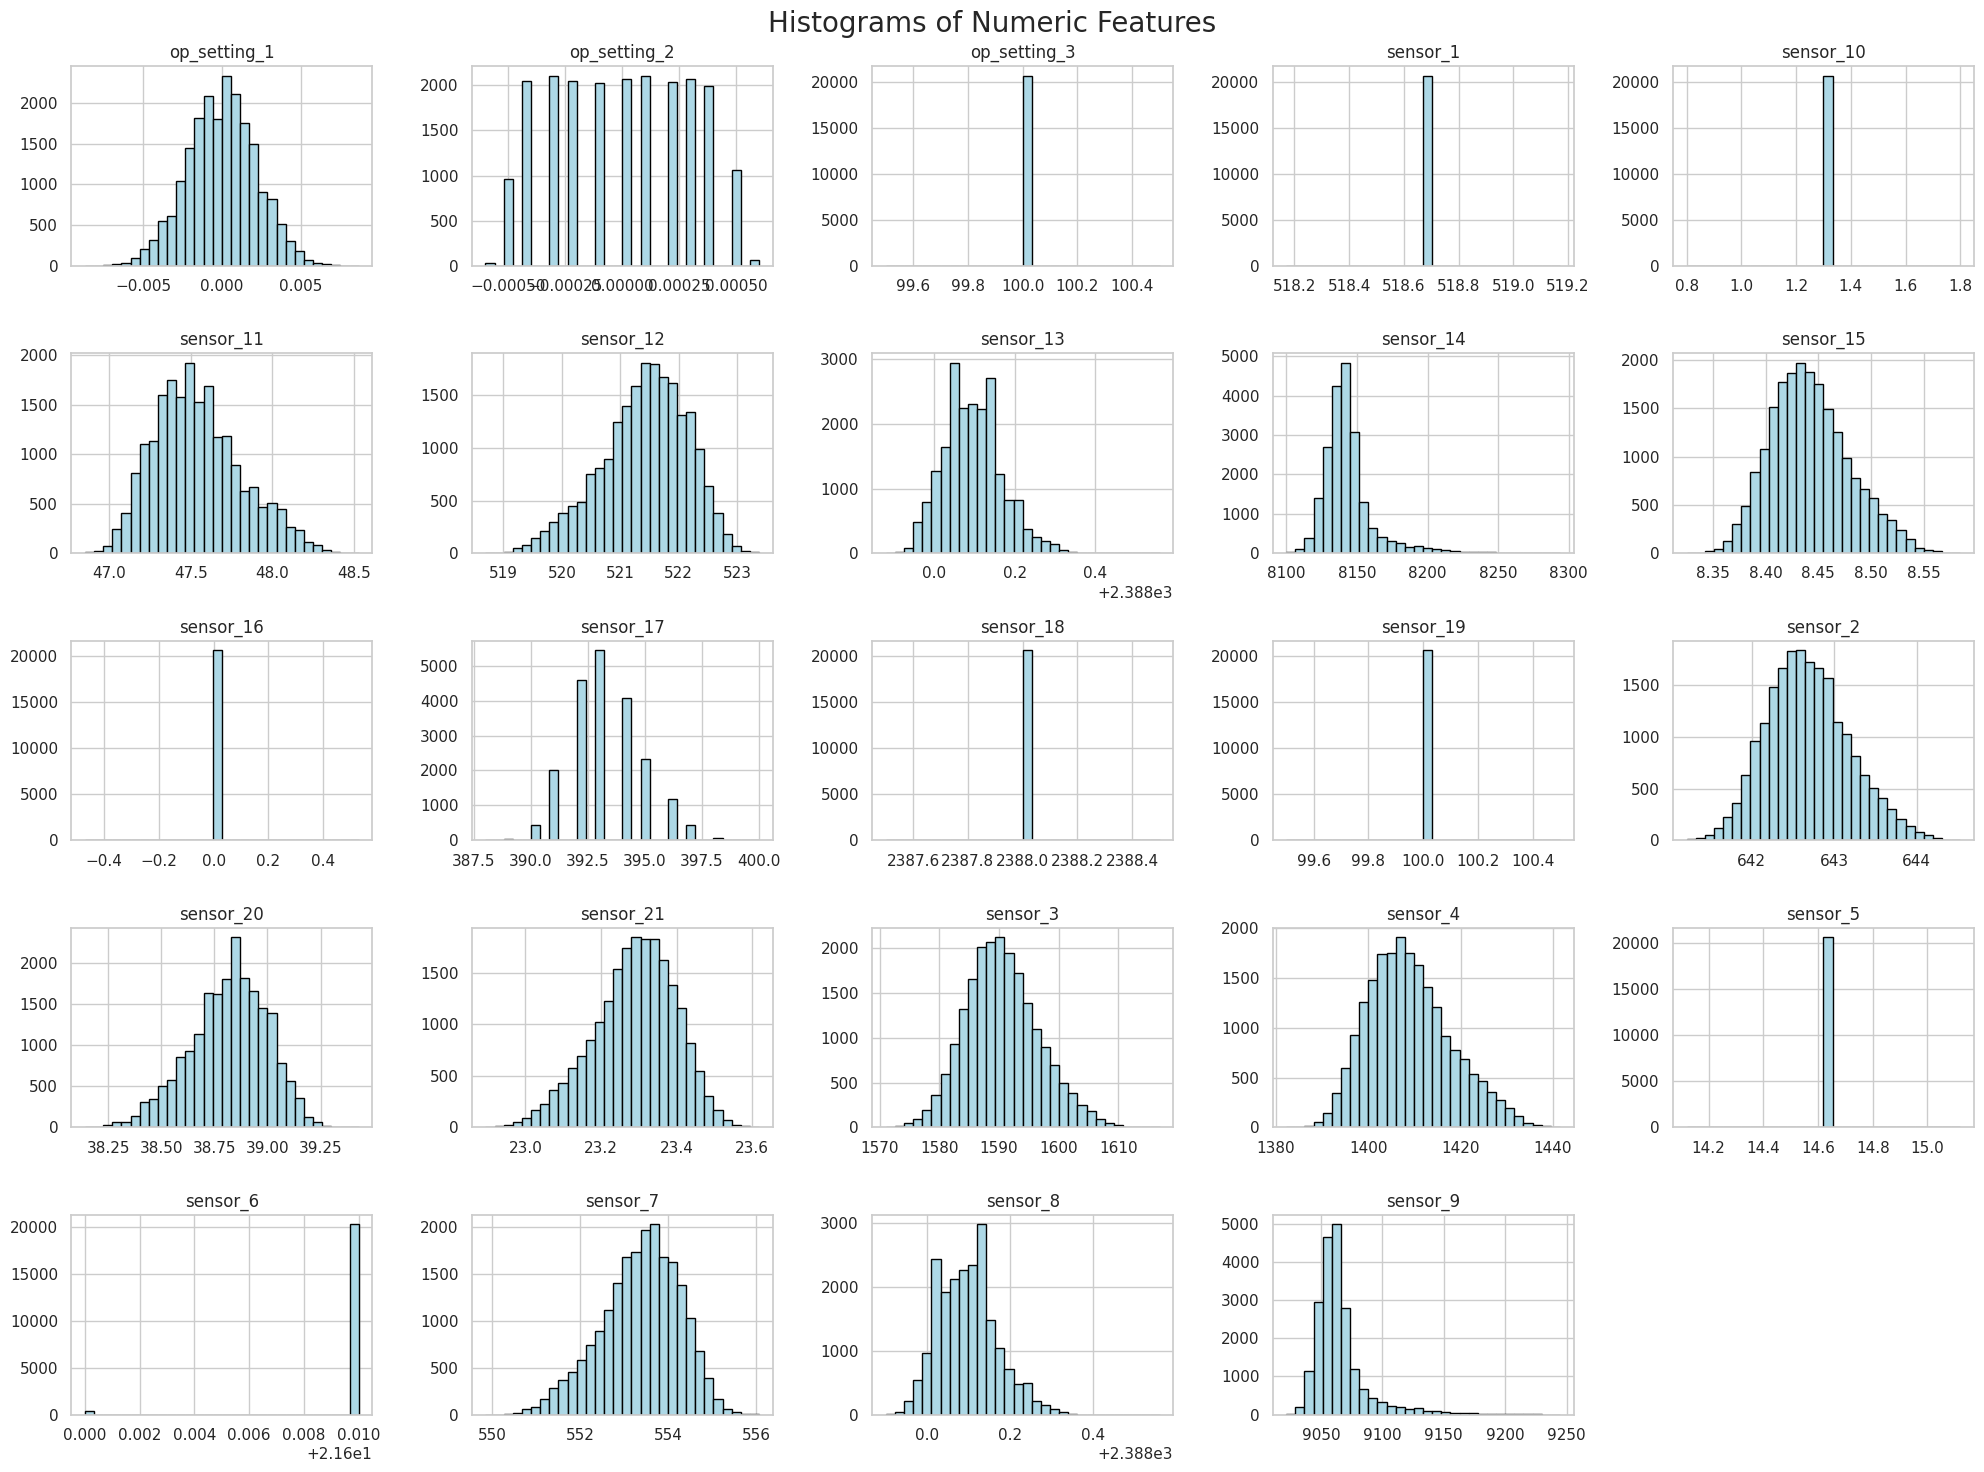

In [8]:
numeric_cols = df.select_dtypes(include=np.number).columns.difference(['unit_number', 'time_in_cycles'])

df[numeric_cols].hist(figsize=(20, 15), bins=30, color='lightblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Features', fontsize=20)
plt.tight_layout()
plt.show()


## Histogram Analysis of Numeric Features

### 1. **Operational Settings**

* **`op_setting_1` and `op_setting_2`**: These are approximately normally distributed and centered around zero, consistent with normalization.
* **`op_setting_3`**: Appears constant at 100 across all records, offering no variance — a candidate for removal.

---

### 2. **Sensors with Near-Constant Values**

Several sensors show a **single dominant bar**, indicating that their values are nearly constant across all records:

* **`sensor_1`, `sensor_5`, `sensor_6`, `sensor_10`, `sensor_16`, `sensor_18`, `sensor_19`**
* These features provide little to no discriminatory power and can likely be excluded from further modeling or dimensionality reduction.

---

### 3. **Sensors with Useful Variability**

These sensors exhibit broader, often bell-shaped distributions, suggesting valuable variability for modeling:

* **`sensor_2`, `sensor_3`, `sensor_4`, `sensor_7`, `sensor_8`, `sensor_9`, `sensor_11`, `sensor_12`, `sensor_13`, `sensor_14`, `sensor_15`, `sensor_17`, `sensor_20`, `sensor_21`**
* Most are symmetric and unimodal; a few are slightly skewed (e.g., `sensor_14` appears right-skewed).

---

### 4. **Insights for Feature Selection**

* **Remove or ignore** near-constant columns to avoid noise or redundant input.
* **Retain** sensors with a normal or skewed distribution, as they hold potential predictive signal for degradation modeling.
* **Check for correlation** among sensors with similar patterns (e.g., `sensor_3` and `sensor_7`) to eliminate redundancy.

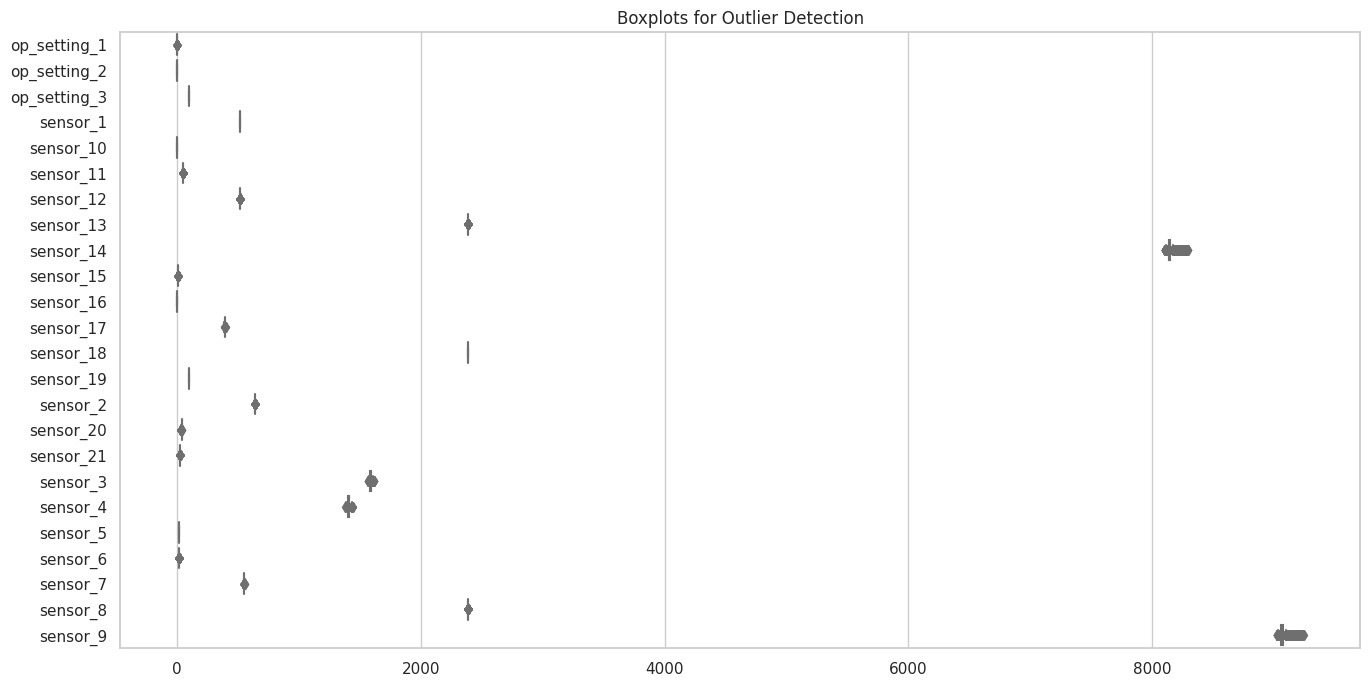

In [9]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[numeric_cols], orient='h', palette='pastel')
plt.title('Boxplots for Outlier Detection')
plt.show()


## 1. **Boxplot for Outlier Detection**

### Observations:

* **`sensor_1`, `sensor_5`, `sensor_6`, `sensor_10`, `sensor_16`, `sensor_18`, `sensor_19`**: Appear as vertical lines with no visible spread, confirming they are **constant or near-constant** and not useful for modeling.
* **Outliers** are visible in:

  * `op_setting_1`, `op_setting_2`: Minor outliers, possibly noise from operational adjustments.
  * `sensor_2`, `sensor_3`, `sensor_4`, `sensor_7`, `sensor_14`, `sensor_20`: Show classic boxplot outliers — values beyond 1.5×IQR — indicating sensors with significant variance and potential fault indicators.
  * `sensor_13`, `sensor_12`: Fewer but present outliers.

### Implication:

Outliers in some sensor values are expected due to engine degradation over cycles. These may represent **early signs of failure** or **sensor noise**. They should not be automatically removed without domain consideration.



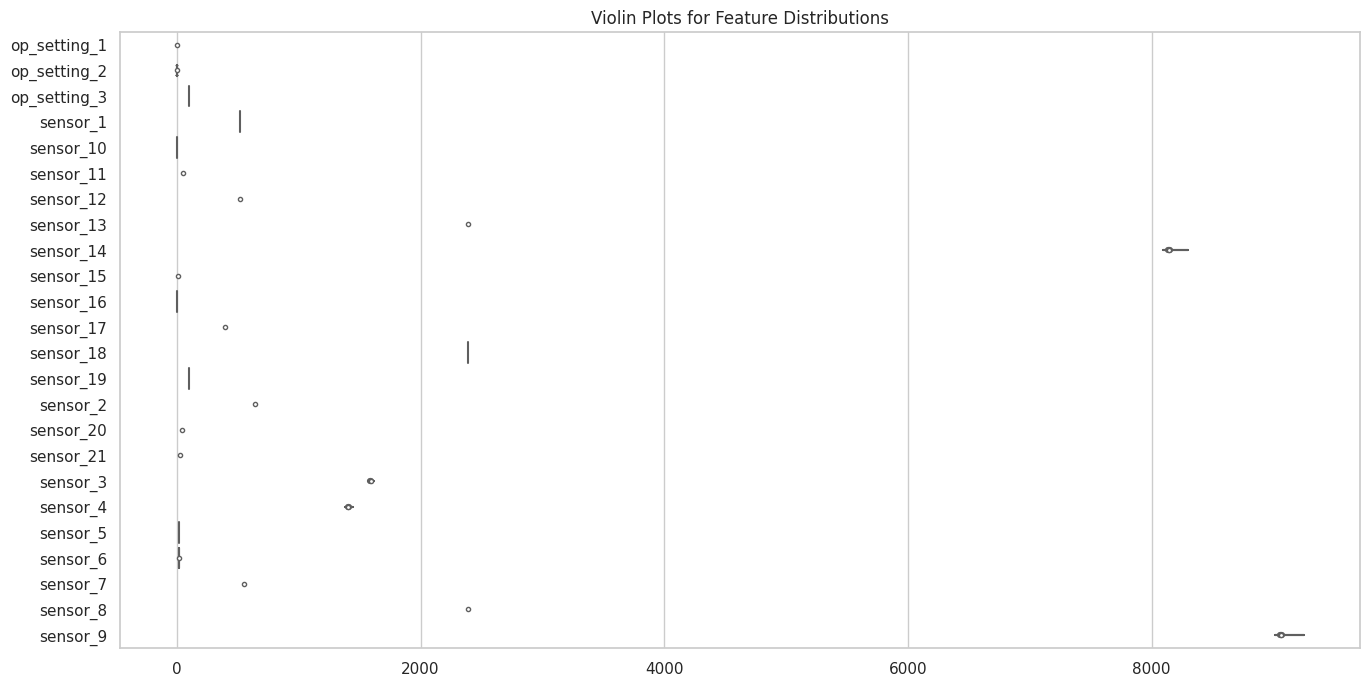

In [10]:
plt.figure(figsize=(16, 8))
sns.violinplot(data=df[numeric_cols], orient='h', palette='Set3')
plt.title('Violin Plots for Feature Distributions')
plt.show()


## 2. **Violin Plots for Feature Distributions**

### Observations:

* Violin plots show **distribution shape + density**:

  * **Bimodal/Multimodal Features**: Some sensors like `sensor_13` and `sensor_20` show denser peaks, suggesting multimodal behavior — possibly indicating operating under different regimes.
  * **Sensor Spread**: `sensor_2`, `sensor_3`, `sensor_4`, `sensor_7`, `sensor_12`, `sensor_14` exhibit broad distributions — indicating useful dynamic range.
  * **Flat/Thin Shapes**: Confirmed again that `sensor_1`, `sensor_5`, `sensor_6`, etc., are near-constant.

### Implication:

Violin plots reinforce which features carry variation useful for prediction. Features with narrow, sharp distributions or thin shapes (i.e., constant features) should be dropped. Features with wide or multi-peaked distributions are good candidates for model input.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


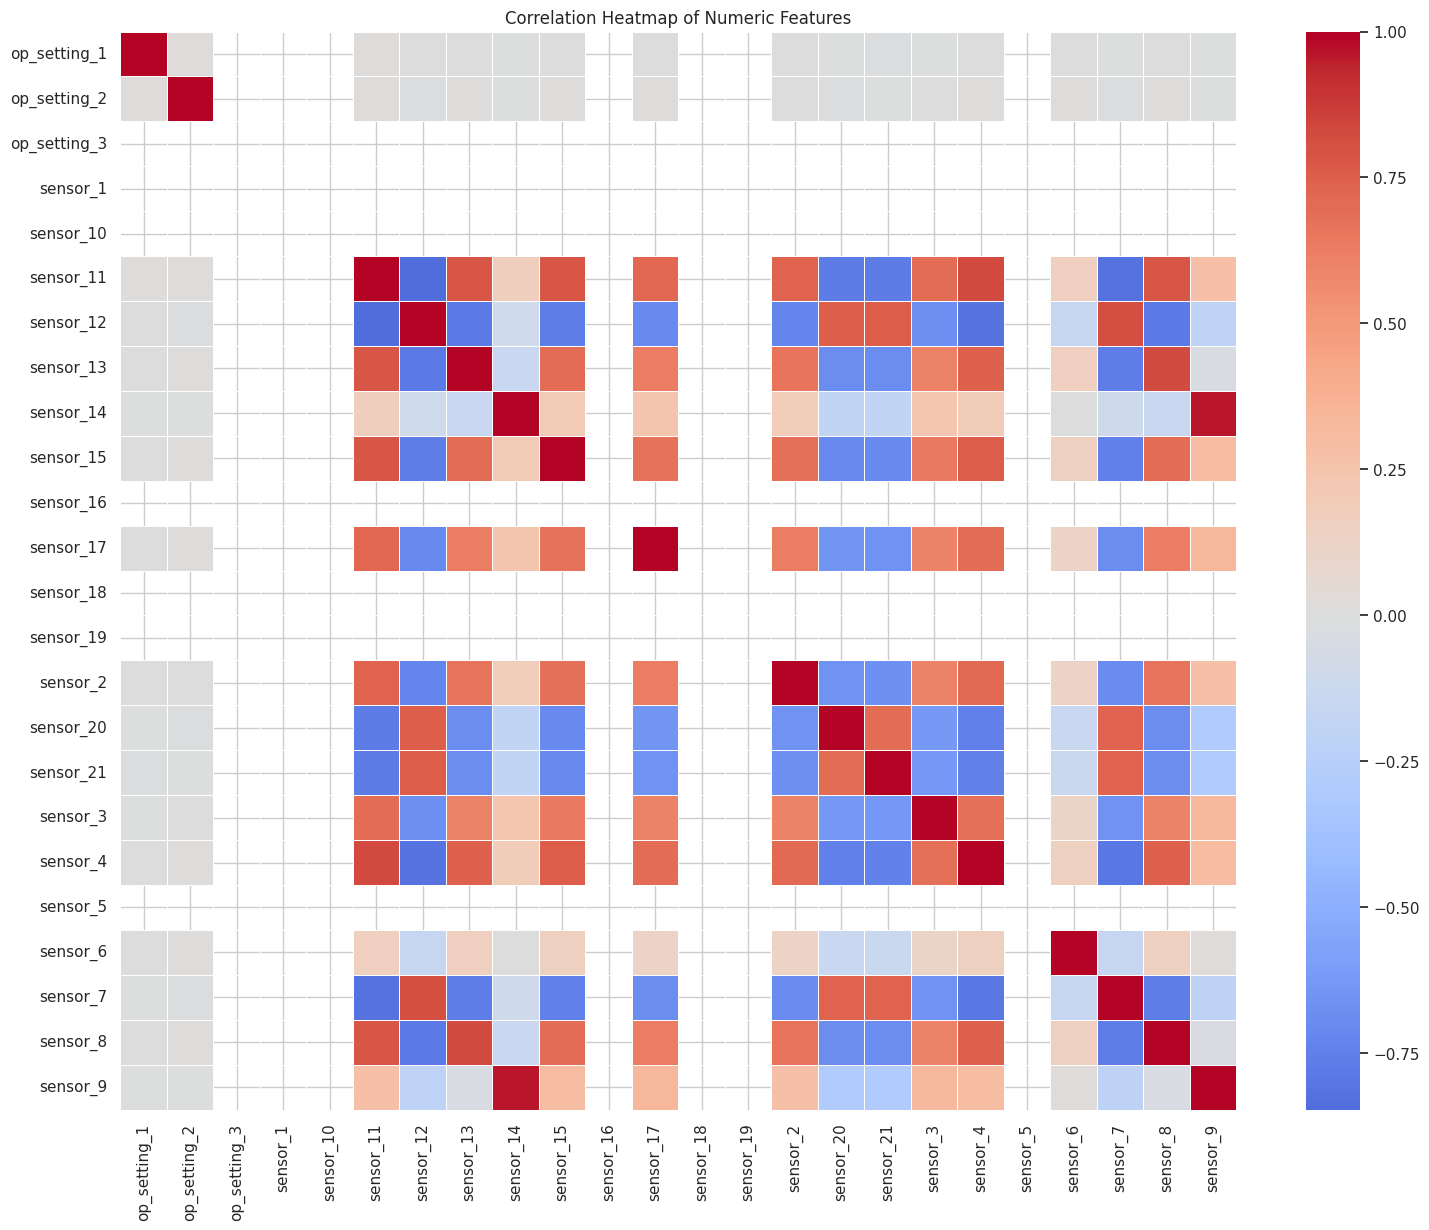

In [11]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


## **Correlation Heatmap of Numeric Features**

### Observations:

* Strong positive correlations between:

  * `sensor_2`, `sensor_3`, and `sensor_4`: Likely monitoring related engine components.
  * `sensor_11`, `sensor_12`, `sensor_13`, `sensor_14`, `sensor_15`: Possible shared system.
* `op_setting_1` and `op_setting_2` are highly **uncorrelated** with sensor features, possibly independently set.
* `sensor_1`, `sensor_5`, `sensor_6`, etc., show **blank/white blocks**, indicating constant or near-constant values (zero variance), which are excluded from correlation computation.

### Implication:

Highly correlated features may introduce multicollinearity in modeling and should be examined for redundancy.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

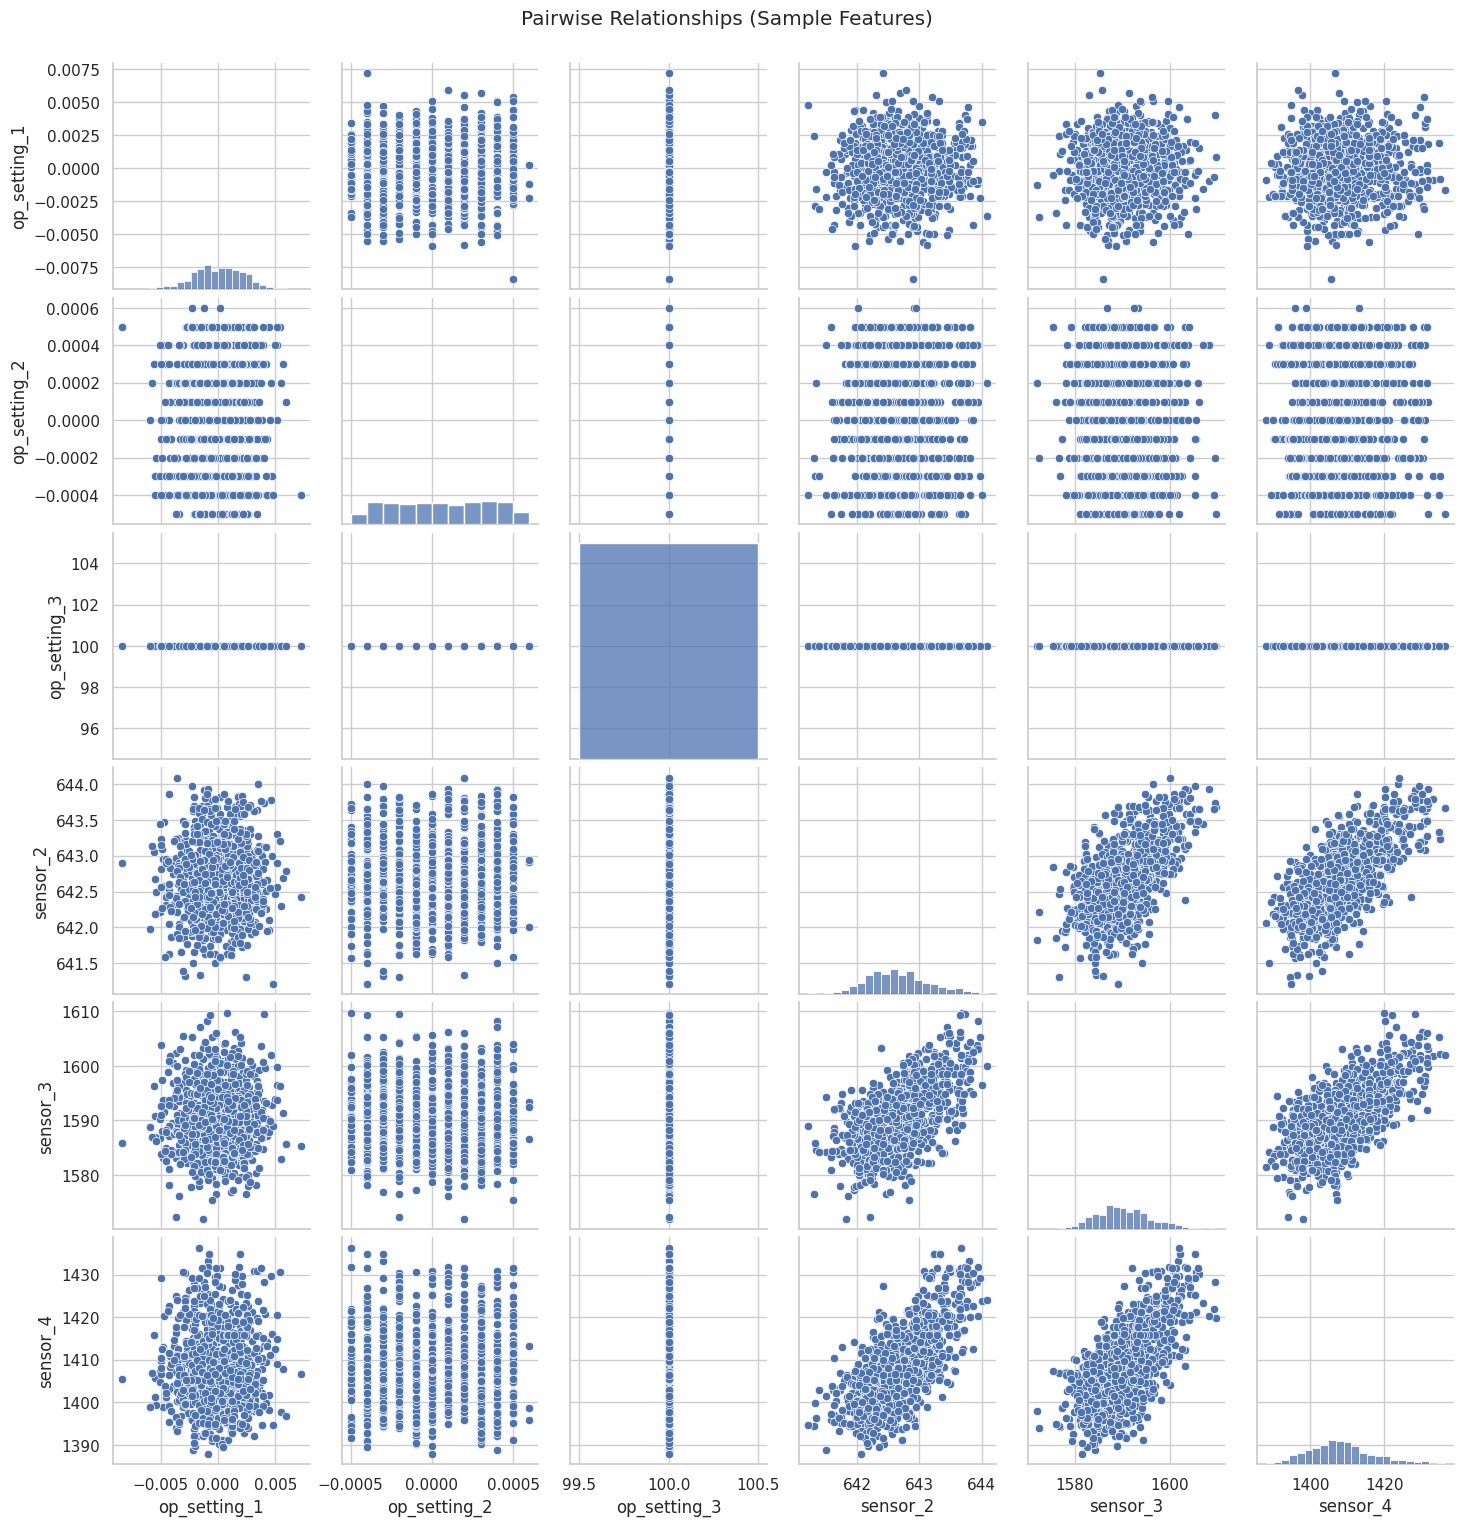

In [12]:
sample_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_2', 'sensor_3', 'sensor_4']
sns.pairplot(df[sample_cols].sample(1000, random_state=42))
plt.suptitle('Pairwise Relationships (Sample Features)', y=1.02)
plt.show()


## **Pairplot (Sample Features)**

### Observations:

* `op_setting_3` is completely flat (constant value = 100), confirming it adds no information.
* Relationships:

  * `sensor_2`, `sensor_3`, and `sensor_4` show **linear trends**, which align with degradation and are useful for prediction.
  * `op_setting_1` and `op_setting_2` exhibit **no clear relation** with sensors.
* Dense vertical and horizontal lines for many features indicate **discrete sensor values** or repeated measurements.

### Implication:

Some sensors exhibit strong mutual relationships suitable for trend modeling, while others (especially operational settings) may require separate treatment or be excluded.

/tmp/ipykernel_35/1833808126.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(zscore(df[numeric_cols]))
/tmp/ipykernel_35/1833808126.py:2: RuntimeWarning: invalid value encountered in greater
  outlier_mask = z_scores > 3


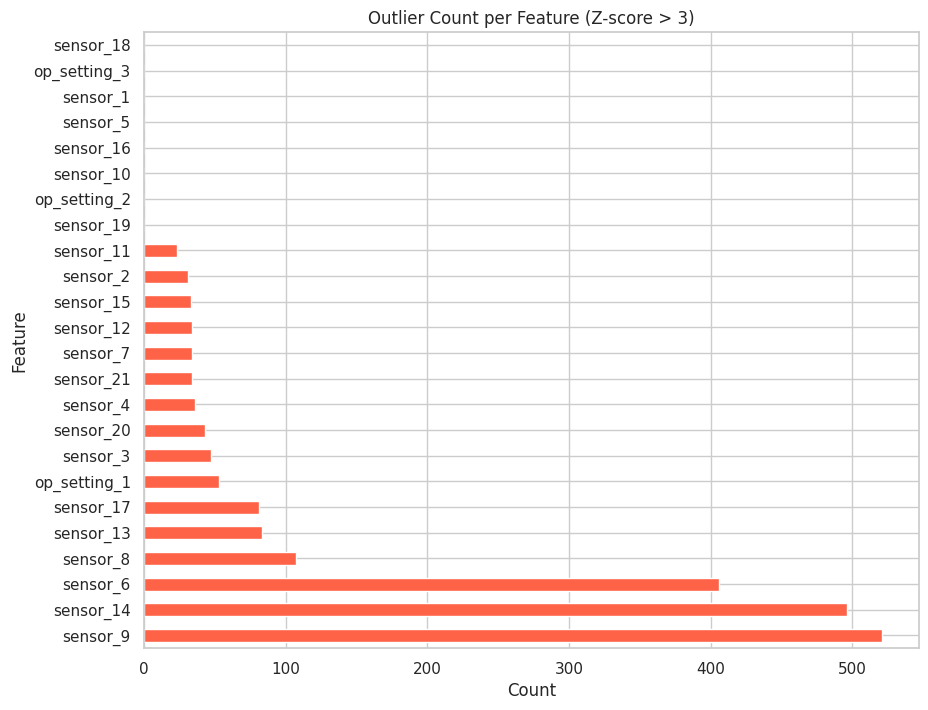

In [13]:
z_scores = np.abs(zscore(df[numeric_cols]))
outlier_mask = z_scores > 3
outlier_counts = pd.Series(outlier_mask.sum(axis=0), index=numeric_cols)

outlier_counts.sort_values(ascending=False).plot(kind='barh', figsize=(10, 8), color='tomato')
plt.title("Outlier Count per Feature (Z-score > 3)")
plt.xlabel("Count")
plt.ylabel("Feature")
plt.show()


## **Z-Score Outlier Count**

### Observations:

* Most features have **low outlier counts**, especially operational settings and constant sensors.
* Features with **most outliers**:

  * `sensor_9`
  * `sensor_14`
  * `sensor_6`
  * `sensor_8`
  * `sensor_13`
* These may contain rare yet informative data or possible measurement errors.

### Implication:

Outlier handling (e.g., capping or removal) may improve model performance. However, in degradation datasets, outliers might indicate failures — so domain context is key.

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


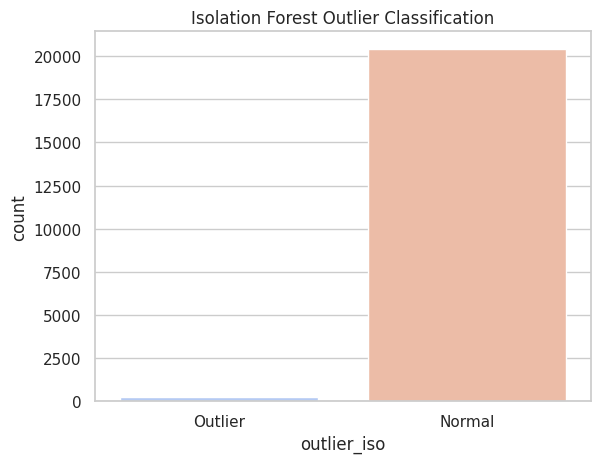

In [14]:
iso = IsolationForest(contamination=0.01, random_state=42)
df['outlier_iso'] = iso.fit_predict(df[numeric_cols])

sns.countplot(x='outlier_iso', data=df, palette='coolwarm')
plt.title('Isolation Forest Outlier Classification')
plt.xticks([0, 1], ['Outlier', 'Normal'])
plt.show()


## **Isolation Forest Outlier Classification**

### Observations:

* Very few rows labeled as outliers (\~0.5%).
* Majority of data is classified as normal.

### Implication:

Isolation Forest confirms that most of the dataset is consistent and clean. Detected anomalies may be useful for failure detection or noise filtering.

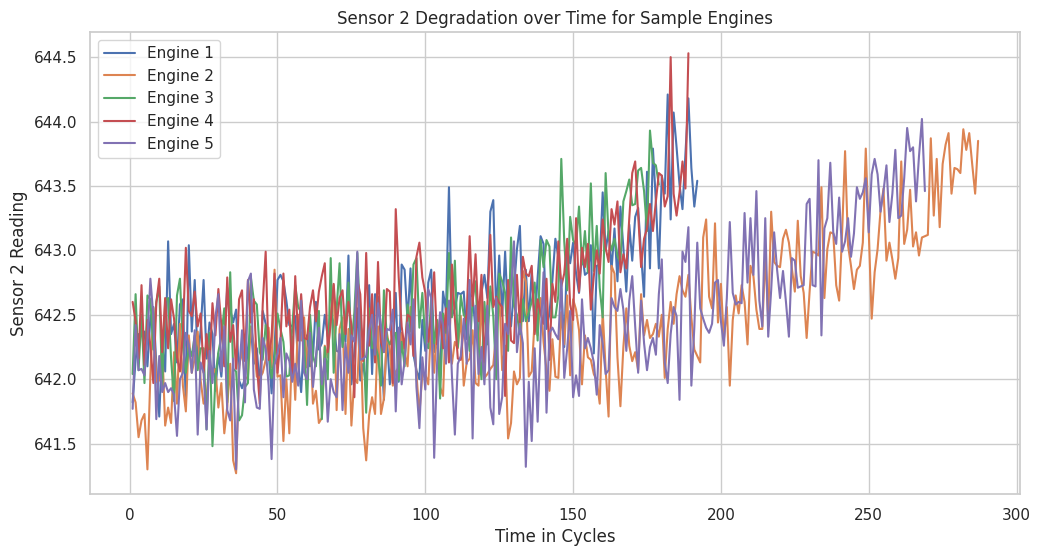

In [15]:
plt.figure(figsize=(12, 6))

for unit in df['unit_number'].unique()[:5]:
    unit_data = df[df['unit_number'] == unit]
    plt.plot(unit_data['time_in_cycles'], unit_data['sensor_2'], label=f'Engine {unit}')

plt.xlabel('Time in Cycles')
plt.ylabel('Sensor 2 Reading')
plt.title('Sensor 2 Degradation over Time for Sample Engines')
plt.legend()
plt.show()


## **Time Series Plot – Sensor 2 Degradation Over Cycles**

### Observations:

* `sensor_2` shows a **gradual upward trend** in some engines, a **stable pattern** in others.
* Fluctuations early in the cycle, followed by gradual changes over time.

### Implication:

This pattern supports **run-to-failure behavior** of turbofan engines. `sensor_2` appears to be a strong candidate for Remaining Useful Life (RUL) prediction due to clear time-dependent degradation.


In [16]:
constant_features = [
    'op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6',
    'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'
]

df_cleaned = df.drop(columns=constant_features)


In [17]:
cor_matrix = df_cleaned.select_dtypes(include='number').corr().abs()
upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

to_drop_corr = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > 0.95)
]

df_reduced = df_cleaned.drop(columns=to_drop_corr)
print("Dropped due to high correlation:", to_drop_corr)


Dropped due to high correlation: ['sensor_14']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [18]:
feature_cols = df_reduced.drop(columns=['unit_number', 'time_in_cycles'], errors='ignore')


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_cols)


In [20]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


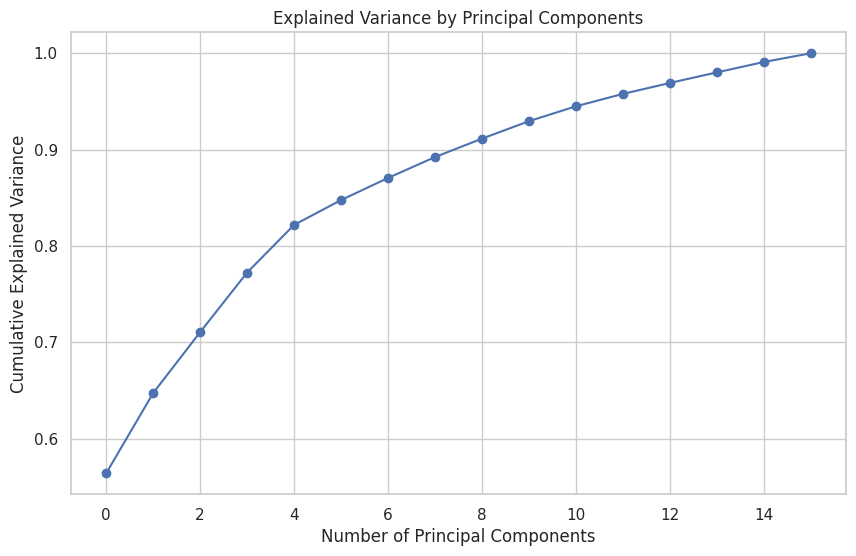

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()


In [22]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(explained_var >= 0.95) + 1
print("Number of components to retain 95% variance:", n_components_95)

pca = PCA(n_components=n_components_95)
X_pca_final = pca.fit_transform(X_scaled)


Number of components to retain 95% variance: 12


In [23]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=feature_cols.columns
)

print(loadings.round(3))


                PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9  \
op_setting_1  0.002 -0.023  0.722 -0.690  0.028  0.018  0.009  0.005 -0.010   
op_setting_2  0.005 -0.037  0.690  0.723 -0.010  0.000 -0.007  0.002  0.004   
sensor_2      0.273  0.025  0.001 -0.010 -0.050 -0.196 -0.613  0.684 -0.075   
sensor_3      0.259  0.100 -0.008  0.010 -0.133  0.917  0.087  0.181 -0.050   
sensor_4      0.300  0.011  0.005 -0.003 -0.045 -0.036 -0.028 -0.097 -0.016   
sensor_7     -0.298  0.065 -0.002  0.001  0.001  0.024 -0.021  0.084 -0.011   
sensor_8      0.283 -0.279 -0.024  0.005  0.194  0.010  0.031 -0.007  0.008   
sensor_9      0.101  0.733  0.034 -0.000 -0.408 -0.086 -0.073 -0.101  0.023   
sensor_11     0.309 -0.017  0.002 -0.007 -0.019 -0.032 -0.029 -0.067  0.009   
sensor_12    -0.304  0.078  0.011 -0.000  0.003  0.017  0.019  0.056 -0.021   
sensor_13     0.283 -0.282 -0.017  0.007  0.194  0.008  0.032 -0.002  0.016   
sensor_15     0.286  0.025  0.005 -0.001 -0.063 -0.0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


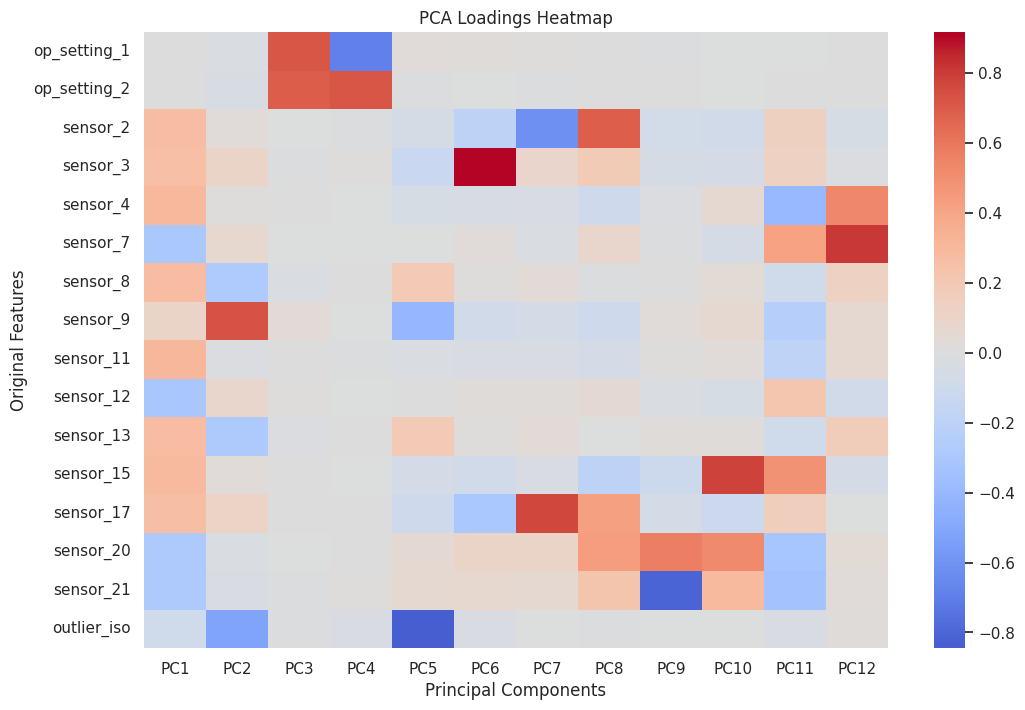

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=False, cmap='coolwarm', center=0)
plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


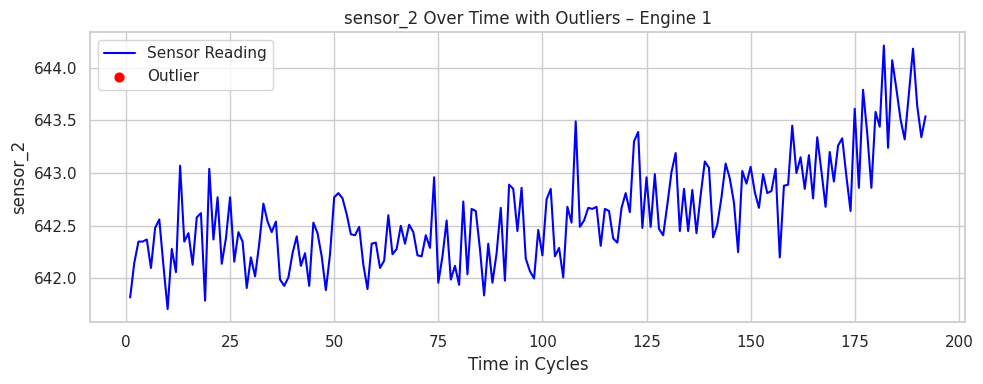

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


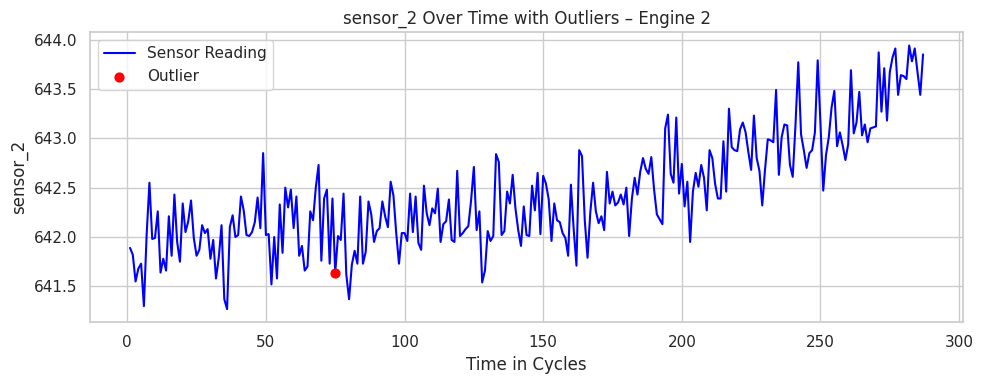

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


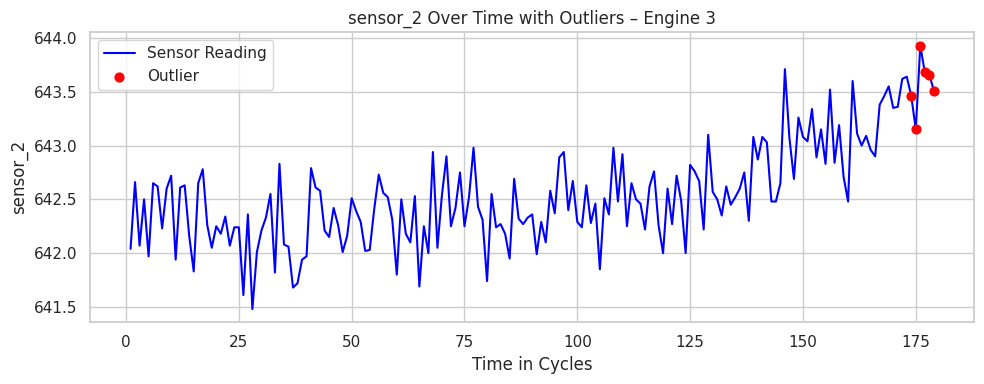

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


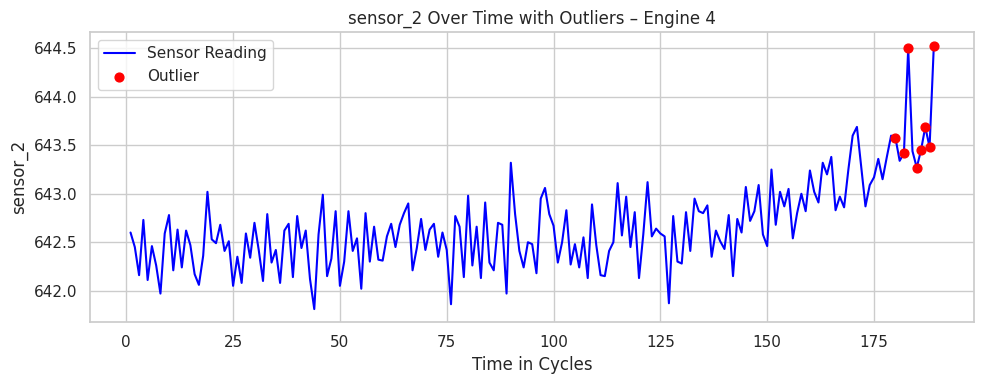

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


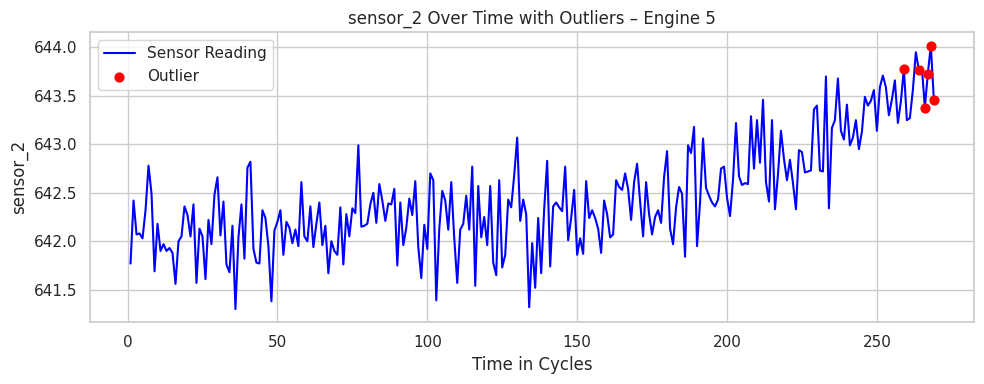

In [25]:
import matplotlib.pyplot as plt

# Convert Isolation Forest labels to a categorical color
df['outlier_label'] = df['outlier_iso'].replace({1: 'normal', -1: 'outlier'})

# Select a sensor to visualize
sensor_col = 'sensor_2'

# Plot for first 5 engines
unique_engines = df['unit_number'].unique()[:5]

for unit in unique_engines:
    data = df[df['unit_number'] == unit]
    
    plt.figure(figsize=(10, 4))
    sns.lineplot(x='time_in_cycles', y=sensor_col, data=data, label='Sensor Reading', color='blue')
    
    outlier_data = data[data['outlier_iso'] == -1]
    plt.scatter(outlier_data['time_in_cycles'], outlier_data[sensor_col], 
                color='red', label='Outlier', zorder=10, s=40)
    
    plt.title(f'{sensor_col} Over Time with Outliers – Engine {unit}')
    plt.xlabel('Time in Cycles')
    plt.ylabel(sensor_col)
    plt.legend()
    plt.tight_layout()
    plt.show()
